In [376]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
from linearmodels.iv import IV2SLS

In [377]:
#Help functions

#Getting the latest exchange rate USD/XXX to standardize across markets. 
def get_exchange_rates(df, colname):
    currencies = df[colname].unique()
    pairs = [f"{currency}USD=X" for currency in currencies if currency != 'USD']
    rates = {}
    for pair in pairs:
        ticker=yf.Ticker(pair)
        query = ticker.history(period = '1d')
        if not query.empty:
            exchange_rate = query['Close'].iloc[-1] #most recent exchange rate
            code = pair.replace("USD=X", "")
            rates[code] = exchange_rate
        else:
            print(f"No data found for {pair}")
    return rates

def output_table(models, fixed_effects):
    if len(fixed_effects) != len(models):
        raise ValueError("Length of FE list must match the number of models.")
    
    all_vars = sorted({var for model in models.values() for var in model.params.index if not var.startswith("C(")})

    def star_format(coef, p):
        return f"{coef:.3f}{'***' if p <= 0.01 else '**' if p <= 0.05 else '*' if p <= 0.1 else ''}"

    results = {
        "Variable": all_vars + ["Observations", "Fixed Effects"],
        **{
            name: [
                star_format(model.params.get(var, float('nan')), model.pvalues.get(var, float('nan'))) 
                if var in model.params else " " 
                for var in all_vars
            ] + [f"{model.nobs:.0f}", fe]
            for (name, model), fe in zip(models.items(), fixed_effects)
        }
    }
    table_df = pd.DataFrame(results)
    latex_output = table_df.to_latex(index=False).splitlines()
    latex_output.insert(-4, r"\midrule")
    return "\n".join(latex_output)

In [378]:
df = pd.read_csv('top_paid_apps_details.csv')
df.head()

,app_id,category,country,advisories,kind,trackContentRating,averageUserRatingForCurrentVersion,averageUserRating,trackCensoredName,fileSizeBytes,...,genreIds,isVppDeviceBasedLicensingEnabled,sellerName,currency,version,wrapperType,userRatingCount,outside_good,in_app,downloads
0,1.125004e+09,6008.0,it,Accesso web senza restrizioni,software,17+,4.19014,4.19014,TV Cast Pro for Fire TV,46334976.0,...,"6008,6016",True,Kraus und Karnath GbR 2Kit Consulting,EUR,3.9,software,142.0,Photo & Video,False,2857.033545
1,4.327914e+08,6012.0,fr,NaN,software,4+,4.79397,4.79397,Cloud Baby Monitor,57482240.0,...,"6012,6003",True,VIGI Limited,EUR,5.7.4,software,199.0,Lifestyle,False,4669.108625
2,3.302471e+08,6010.0,jp,NaN,software,4+,4.65268,4.65268,"Sun Seeker: サンサーベイヤー, 日の出日の入り",37025792.0,...,"6010,6008",True,Ajnaware Pty Ltd,JPY,7.0,software,1621.0,outside,False,32733.288751
3,8.911946e+08,6014.0,se,Tecknat eller fantasy med inslag av ofta förek...,software,12+,4.51121,4.51121,Earn to Die 2,77543424.0,...,"6014,7013,7001",True,Not Doppler Pty Limited,SEK,1.4.55,software,223.0,Games,True,7395.511298
4,1.456275e+09,6017.0,gb,"Infrequent/Mild Alcohol, Tobacco, or Drug Use ...",software,12+,4.83664,4.83664,CITB Op/Spec HS&E test,158105600.0,...,"6017,6006",True,CITB-ConstructionSkills,GBP,6.0.40,software,3563.0,Education,False,72299.889597


In [379]:
#Exploring the features of the data.
print(f"{df['app_id'].nunique()} apps (products).")
print(f"{df['country'].nunique()} countries (markets).")
print(f"{df['sellerName'].nunique()} firms.")

2020 apps (products).
11 countries (markets).
1401 firms.


In [380]:
#Building the dataset from scraped app store data.

app_data = df[['app_id', 
               'price', 
               'primaryGenreId',
               'country', 
               'sellerName', 
               'outside_good', 
               'downloads', 
               'currency', 
               'fileSizeBytes', 
               'releaseDate',
               'userRatingCount',
               'averageUserRating',
               'contentAdvisoryRating',
               'in_app'
               ]].copy()

app_data.set_index('app_id', inplace = True)
app_data.sort_index(inplace=True)
app_data['releaseDate'] = pd.to_datetime(app_data['releaseDate'], format='%Y-%m-%dT%H:%M:%SZ') #Format the release date

#Replace NaN category for App: Procreate Pocket with true value
app_data.fillna({'category':6027.0}, inplace=True)

#Standardizing prices to USD. 
er = get_exchange_rates(app_data, 'currency')
app_data['price'] = app_data.apply(lambda row: row['price'] * er.get(row['currency'], 1), axis=1)
app_data.drop(columns=['currency'], inplace=True)

#Computing market shares for each of the 11 markets
app_data['market_share'] = app_data['downloads'] / app_data.groupby('country')['downloads'].transform('sum')

#Computing market shares of the outside option in each market.
s_0m = app_data[app_data['outside_good'] == 'outside'].groupby('country')['downloads'].sum() / app_data.groupby('country')['downloads'].sum() #share of outside good in market m

#Compute the log difference
app_data = app_data.merge(s_0m.rename('s_0m'), on='country', how='left')
app_data['log_diff'] = np.where(
    app_data['outside_good'] == 'outside',
    np.nan, 
    np.log(app_data['market_share']) - np.log(app_data['s_0m'])
    ) 

app_data.drop(columns=['s_0m'], inplace=True)

#Building the price instrument
app_data['apps_in_genre'] = app_data.groupby(['primaryGenreId', 'country'])['primaryGenreId'].transform('count')

#Convert release date into months since release.
app_data['months_since_release'] = app_data['releaseDate'].apply(lambda x: (datetime.now().year - x.year) * 12 + datetime.now().month - x.month)
app_data.drop(columns=['releaseDate'],inplace=True)

#Convert filesize to MB (for convenience)
app_data['fileSize'] = app_data['fileSizeBytes'] / (1024 ** 2)
app_data.drop(columns=['fileSizeBytes'],inplace=True)

#Convert dummy variables.
app_data = pd.get_dummies(app_data, columns=['contentAdvisoryRating'], drop_first=True)
app_data.columns = [col.replace('+', '') for col in app_data.columns]
categorical = app_data.select_dtypes(include='bool').columns
app_data[categorical] = app_data[categorical].astype(int)

app_data.head()


,price,primaryGenreId,country,sellerName,outside_good,downloads,userRatingCount,averageUserRating,in_app,market_share,log_diff,apps_in_genre,months_since_release,fileSize,contentAdvisoryRating_17,contentAdvisoryRating_4,contentAdvisoryRating_9
0,10.705100,6014.0,it,Solebon LLC,Games,2889.232246,143.0,4.66434,1,0.000162,-5.545677,207,69,168.185547,0,1,0
1,10.705100,6014.0,es,Solebon LLC,Games,1293.227616,64.0,4.75000,1,0.000069,-5.687151,205,69,168.185547,0,1,0
2,10.705100,6014.0,gr,Solebon LLC,Games,424.366007,21.0,4.71429,1,0.000119,-5.551615,208,69,168.185547,0,1,0
3,12.897978,6014.0,gb,Solebon LLC,Games,44292.892376,1708.0,4.78806,1,0.000527,-3.438229,221,69,168.185547,0,1,0
4,10.705100,6014.0,nl,Solebon LLC,Games,3394.223564,168.0,4.74404,1,0.000049,-4.802529,204,69,168.185547,0,1,0


In [381]:
app_data_reg = app_data.dropna(subset=['log_diff']).copy()

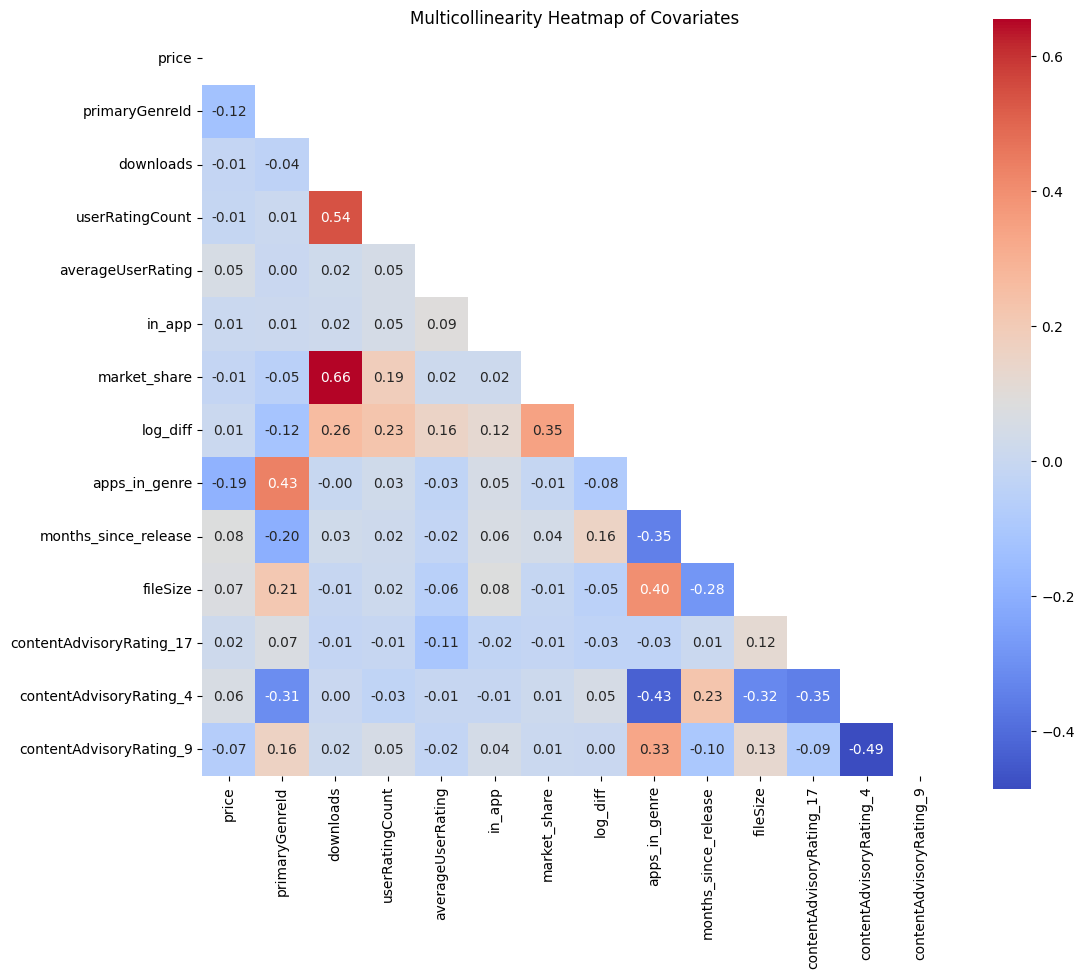

In [382]:
#Check multicollinearity

corr = app_data.select_dtypes(include = ['float64', 'int64']).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask = mask, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Multicollinearity Heatmap of Covariates")
plt.show()


In [383]:
#Logit estimation without instruments
form_1 = 'log_diff ~ price + averageUserRating + fileSize + months_since_release + in_app + contentAdvisoryRating_17 + contentAdvisoryRating_4 + contentAdvisoryRating_9 + C(country)'
ols1 = sm.ols(formula=form_1, data=app_data_reg).fit()
print(ols1.summary())

                            OLS Regression Results                            
Dep. Variable:               log_diff   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     89.78
Date:                Sun, 10 Nov 2024   Prob (F-statistic):          1.78e-287
Time:                        23:25:31   Log-Likelihood:                -8919.3
No. Observations:                5069   AIC:                         1.788e+04
Df Residuals:                    5050   BIC:                         1.800e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [384]:
#Regression with instruments for prices.
form_2 = 'log_diff ~ [price ~ apps_in_genre] + averageUserRating + fileSize + months_since_release + in_app + contentAdvisoryRating_17 + contentAdvisoryRating_4 + contentAdvisoryRating_9 + C(country) +1'
iv1 = IV2SLS.from_formula(form_2, data=app_data_reg).fit()
print(iv1.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:               log_diff   R-squared:                      0.2397
Estimator:                    IV-2SLS   Adj. R-squared:                 0.2370
No. Observations:                5069   F-statistic:                    1623.1
Date:                Sun, Nov 10 2024   P-value (F-stat)                0.0000
Time:                        23:25:31   Distribution:                 chi2(18)
Cov. Estimator:                robust                                         
                                                                              
                                    Parameter Estimates                                     
                          Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------
Intercept                   -6.2323     0.2581    -24.149     0.0000     -6.7381     -5.7

In [385]:
print(iv1.first_stage)

    First Stage Estimation Results    
                                 price
--------------------------------------
R-squared                       0.0713
Partial R-squared               0.0379
Shea's R-squared                0.0379
Partial F-statistic             302.76
P-value (Partial F-stat)        0.0000
Partial F-stat Distn           chi2(1)
========================== ===========
Intercept                       0.0506
                              (0.0394)
averageUserRating               1.4850
                              (6.4226)
fileSize                        0.0029
                              (11.968)
months_since_release            0.0112
                              (3.2360)
in_app                         -0.2111
                             (-0.7248)
contentAdvisoryRating_17        0.8167
                              (1.4620)
contentAdvisoryRating_4         0.6806
                              (3.0069)
contentAdvisoryRating_9         0.3859
                         

In [386]:
#Create within-category market share of of app j in market m
app_data['log_within_group_share'] = np.log(app_data['downloads'] / app_data.groupby(['outside_good', 'country'])['downloads'].transform('sum'))
#app_data['avg_other_firms_rating'] = app_data.groupby('outside_good')['userRatingCount'].transform(lambda x: (x.sum() - x) / (len(x) - 1))

app_data_reg2 = app_data.dropna(subset=['log_diff']).copy()

In [387]:
#Run nested logit without instruments for prices
form_3 = 'log_diff ~ price + log_within_group_share + averageUserRating + fileSize + months_since_release + in_app + contentAdvisoryRating_17 + contentAdvisoryRating_4 + contentAdvisoryRating_9 + C(country)'
ols2 = sm.ols(formula=form_3, data=app_data_reg2).fit()
print(ols2.summary())

                            OLS Regression Results                            
Dep. Variable:               log_diff   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     340.5
Date:                Sun, 10 Nov 2024   Prob (F-statistic):               0.00
Time:                        23:25:31   Log-Likelihood:                -7532.7
No. Observations:                5069   AIC:                         1.511e+04
Df Residuals:                    5049   BIC:                         1.524e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [388]:
#Run nested logit with instruments for prices
form_4 = 'log_diff ~ [price ~ apps_in_genre] + log_within_group_share + averageUserRating + fileSize + months_since_release + in_app + contentAdvisoryRating_17 + contentAdvisoryRating_4 + contentAdvisoryRating_9 + C(country) +1'
iv2 = IV2SLS.from_formula(form_4, data=app_data_reg2).fit()
print(iv2.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:               log_diff   R-squared:                     -3.8556
Estimator:                    IV-2SLS   Adj. R-squared:                -3.8739
No. Observations:                5069   F-statistic:                    798.42
Date:                Sun, Nov 10 2024   P-value (F-stat)                0.0000
Time:                        23:25:31   Distribution:                 chi2(19)
Cov. Estimator:                robust                                         
                                                                              
                                    Parameter Estimates                                     
                          Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------
Intercept                   -2.4660     0.5359    -4.6015     0.0000     -3.5164     -1.4

In [389]:
print(iv2.first_stage)

    First Stage Estimation Results    
                                 price
--------------------------------------
R-squared                       0.0755
Partial R-squared               0.0382
Shea's R-squared                0.0382
Partial F-statistic             234.07
P-value (Partial F-stat)        0.0000
Partial F-stat Distn           chi2(1)
========================== ===========
Intercept                      -2.6542
                             (-1.7724)
log_within_group_share         -0.4227
                             (-4.3277)
averageUserRating               1.6789
                              (7.0820)
fileSize                        0.0029
                              (12.103)
months_since_release            0.0124
                              (3.5609)
in_app                         -0.1256
                             (-0.4353)
contentAdvisoryRating_17        0.8509
                              (1.5323)
contentAdvisoryRating_4         0.6670
                         

In [390]:
#Output the latex table
models = {"Logit (OLS)": ols1, "Logit (TSLS)": iv1, "Nested Logit (OLS)": ols2, "Nested Logit (TSLS)": iv2}
latex = output_table(models, ["Yes", "Yes", "Yes", "Yes"])
print(latex)

\begin{tabular}{lllll}
\toprule
Variable & Logit (OLS) & Logit (TSLS) & Nested Logit (OLS) & Nested Logit (TSLS) \\
\midrule
Intercept & -6.279*** & -6.232*** & -1.701*** & -2.466*** \\
averageUserRating & 0.393*** & 0.379*** & 0.142*** & 0.645*** \\
contentAdvisoryRating_17 & 0.040 & 0.021 & -0.415*** & 0.267 \\
contentAdvisoryRating_4 & 0.124** & 0.104 & -0.332*** & 0.367*** \\
contentAdvisoryRating_9 & 0.201*** & 0.203*** & 0.290*** & 0.211** \\
fileSize & 0.000 & 0.000 & 0.000*** & 0.001*** \\
in_app & 0.269*** & 0.273*** & 0.239*** & 0.078 \\
log_within_group_share &   &   & 0.471*** & 0.586*** \\
months_since_release & 0.003*** & 0.003*** & -0.001 & 0.006*** \\
price & -0.003* & 0.005 & -0.009*** & -0.355*** \\
\midrule
Observations & 5069 & 5069 & 5069 & 5069 \\
Fixed Effects & Yes & Yes & Yes & Yes \\
\bottomrule
\end{tabular}


In [391]:
#Create a dataframe with only US data (single market)

app_data_us = app_data[app_data['country'] == 'us'].copy()
app_data_us.sort_index(inplace=True)
app_data_us_reg = app_data_us.dropna(subset=['log_diff']).copy()
app_data_us_reg.head()

,price,primaryGenreId,country,sellerName,outside_good,downloads,userRatingCount,averageUserRating,in_app,market_share,log_diff,apps_in_genre,months_since_release,fileSize,contentAdvisoryRating_17,contentAdvisoryRating_4,contentAdvisoryRating_9,log_within_group_share
8,9.99,6014.0,us,Solebon LLC,Games,5.899981e+05,30511.0,4.82409,1,0.001347,-3.229222,217,69,168.185547,0,1,0,-5.984236
14,4.99,6014.0,us,Digital Smoke,Games,8.422578e+04,4062.0,4.60881,0,0.000192,-5.175840,217,69,44.964844,0,1,0,-7.930855
26,4.99,6014.0,us,MobilityWare,Games,2.807076e+07,128052.0,4.77010,0,0.064089,0.633143,217,69,223.625000,0,1,0,-2.121872
34,4.99,6014.0,us,MobilityWare,Games,1.023905e+06,20893.0,4.79840,0,0.002338,-2.677962,217,69,222.923828,0,1,0,-5.432977
40,9.99,6012.0,us,Universalis Publishing Limited,Lifestyle,1.142785e+05,5738.0,4.91669,1,0.000261,-4.870703,13,70,83.519531,0,1,0,-2.578708


In [392]:
#Run the Berry Logit on only US app data
form_5 = 'log_diff ~ [price ~ apps_in_genre] + averageUserRating + fileSize + months_since_release + in_app + contentAdvisoryRating_17 + contentAdvisoryRating_4 + contentAdvisoryRating_9 + 1'
iv3 = IV2SLS.from_formula(form_5, data=app_data_us_reg).fit()
print(iv3.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:               log_diff   R-squared:                     -0.0450
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0636
No. Observations:                 457   F-statistic:                    18.766
Date:                Sun, Nov 10 2024   P-value (F-stat)                0.0162
Time:                        23:25:31   Distribution:                  chi2(8)
Cov. Estimator:                robust                                         
                                                                              
                                    Parameter Estimates                                     
                          Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------
Intercept                   -6.8546     1.1906    -5.7575     0.0000     -9.1880     -4.5

In [393]:
app_data_us_reg['sellerName'].unique().size

347

In [394]:
#Cost estimation

def cost_estimation(dataframe, *args, share_col = 'market_share', price_col = 'price', firm_col = 'sellerName'):
    df = dataframe.copy()
    shares = df[share_col].values
    prices = df[price_col].values
    firms = df[firm_col].values
    J = len(shares)
    output = []
    for arg in args:
        Omega_star = np.zeros((J, J))
        S = np.zeros((J, J))
        for j in range(J):
             for r in range(J):
                if j == r:
                    S[j, r] = -arg * prices[j] * (1 - shares[j]) #Own-price elasticity 
                else:
                    S[j, r] = arg * prices[r] * shares[r] #Cross-price elasticity
        for j in range(J):
            for r in range(J):
                if firms[j] == firms[r]:  # Products j and r belong to the same firm
                    Omega_star[j, r] = 1
        Omega = Omega_star * S
        output.append([Omega, S])
    return(output)
#Note: negative sign in Nevo for FOC S_jr = - ds_r / dp_j for all r, j = 1,...,J, 

In [395]:
Omega = cost_estimation(app_data_us_reg, iv3.params['price'])[0][0]
prices = app_data_us_reg['price'].values
shares = app_data_us_reg['market_share'].values

s_p = shares.reshape(-1,1)
p = prices.reshape(-1,1)

Omega_inv = np.linalg.inv(Omega)
markups = Omega_inv @ s_p
mc = p - markups

pcm_current = (markups / p) * 100

print(f'Average PCM (current ownership): {pcm_current.mean().round(4)}%')
print(f'Largest PCM (current ownership): {pcm_current.max().round(4)}%')
print(f'Smallest PCM (current ownership): {pcm_current.min().round(4)}%')

print(f'Minimum marginal cost: {mc.min().round(4)}')
print(f'Average marginal cost: {mc.mean().round(4)}')
print(f'Maximum marginal cost: {mc.max().round(4)}')


Average PCM (current ownership): 1.0592%
Largest PCM (current ownership): 100.7429%
Smallest PCM (current ownership): 0.0001%
Minimum marginal cost: -0.0074
Average marginal cost: 6.0933
Maximum marginal cost: 59.99


In [396]:
latex_table = f"""
\\begin{{table}}[h!]
    \\centering
    \\begin{{tabular}}{{|l|c|c|}}
        \\hline
        & \\textbf{{Markup}} & \\textbf{{Marginal Cost}} \\\\
        \\hline
        Minimum & {pcm_current.min().round(4)}\% & {mc.min().round(4)} \\\\
        \\hline
        Average & {pcm_current.mean().round(4)}\% & {mc.mean().round(4)} \\\\
        \\hline
        Maximum & {pcm_current.max().round(4)}\% & {mc.max().round(4)} \\\\
        \\hline
    \\end{{tabular}}
    \\caption{{Summary of markups and marginal costs}}
    \\label{{tab:markup_marginal_cost}}
\\end{{table}}
"""
print(latex_table)


\begin{table}[h!]
    \centering
    \begin{tabular}{|l|c|c|}
        \hline
        & \textbf{Markup} & \textbf{Marginal Cost} \\
        \hline
        Minimum & 0.0001\% & -0.0074 \\
        \hline
        Average & 1.0592\% & 6.0933 \\
        \hline
        Maximum & 100.7429\% & 59.99 \\
        \hline
    \end{tabular}
    \caption{Summary of markups and marginal costs}
    \label{tab:markup_marginal_cost}
\end{table}



In [397]:
#Different scenarios: S is the same but we change the ownership. 
J = len(shares)
S = cost_estimation(app_data_us_reg, iv3.params['price'])[0][1]


In [398]:
#One-product firms
Omega_single_product = np.identity(J) * S
markup_1 = np.linalg.inv(Omega_single_product) @ s_p
pcm_single_prod_firm = (markup_1 /p) * 100 #Element-wise division

print(f'Average PCM (single-product): {pcm_single_prod_firm.mean().round(4)}%')
print(f'Largest PCM (single-product): {pcm_single_prod_firm.max().round(4)}%')
print(f'Smallest PCM (single-product): {pcm_single_prod_firm.min().round(4)}%')

# df = app_data_us_reg[['price', 'sellerName','outside_good']].copy()
# df['markup'] = markup
# df['pcm'] = pcm_single_firm

# firm_markup = df.groupby('sellerName')['markup'].sum()
# firm_markup.idxmax()

# df[df['sellerName'] == 'Ndemic Creations LTD']

Average PCM (single-product): 1.05%
Largest PCM (single-product): 100.7044%
Smallest PCM (single-product): 0.0001%


In [399]:
#Monopolist
Omega_monopolist = np.ones((J,J)) * S
markup_2 = np.linalg.inv(Omega_monopolist) @ s_p
pcm_monopolist = (markup_2 / p) * 100

print(f'Average PCM (Monopolist): {pcm_monopolist.mean().round(4)}%')
print(f'Largest PCM (Monopolist): {pcm_monopolist.max().round(4)}%')
print(f'Smallest PCM (Monopolist): {pcm_monopolist.min().round(4)}%')

#Note: some implied MC are negative - to set the observed prices, monopolist would have to be subsidized. 

Average PCM (Monopolist): 537.0992%
Largest PCM (Monopolist): 28210.5695%
Smallest PCM (Monopolist): 0.658%


In [400]:
#Confidence bands: c indicates current, s indicates single-product, m indicated monopolist
interval = iv3.conf_int().loc['price']

results = cost_estimation(app_data_us_reg, interval.iloc[0], interval.iloc[1])

pcm_lc = (np.linalg.inv(results[0][0] * results[0][1]) @ s_p)/p
pcm_uc = (np.linalg.inv(results[1][0] * results[1][1]) @ s_p)/p

pcm_ls = (np.linalg.inv(np.identity(J) * results[0][1]) @ s_p)/p
pcm_us = (np.linalg.inv(np.identity(J) * results[1][1]) @ s_p)/p

pcm_lm = (np.linalg.inv(np.ones((J,J)) * results[0][1]) @ s_p)/p
pcm_um = (np.linalg.inv(np.ones((J,J)) * results[1][1])@ s_p)/p

print(f'Current ownership: [{pcm_lc.mean()}%, {pcm_uc.mean()}%] \n Single product: [{pcm_ls.mean()}%, {pcm_us.mean()}%] \n Monopolist: [{pcm_lm.mean()}%,{pcm_um.mean()}%]')

Current ownership: [0.05085708800553069%, 7.287595436804586%] 
 Single product: [0.004811635041325049%, -0.05759821994128295%] 
 Monopolist: [2.461155167858894%,-29.461535517648862%]


In [401]:
latex_table = f"""
\\begin{{table}}[h!]
    \\centering
    \\begin{{tabular}}{{|l|c|}}
        \\hline
        \\textbf{{Scenario}} & \\textbf{{Mean Price-Cost Markup}} \\\\
        \\hline
        Current Ownership & {pcm_current.mean().round(3)}\% \\\\
        \\hline
        Single Product Firms & {pcm_single_prod_firm.mean().round(3)}\% \\\\
        \\hline
        Monopolist & {pcm_monopolist.mean().round(3)}\% \\\\
        \\hline
    \\end{{tabular}}
    \\caption{{Mean Price-Cost Margins for Different Scenarios}}
    \\label{{tab:pcm_means}}
\\end{{table}}
"""
print(latex_table)


\begin{table}[h!]
    \centering
    \begin{tabular}{|l|c|}
        \hline
        \textbf{Scenario} & \textbf{Mean Price-Cost Markup} \\
        \hline
        Current Ownership & 1.059\% \\
        \hline
        Single Product Firms & 1.05\% \\
        \hline
        Monopolist & 537.099\% \\
        \hline
    \end{tabular}
    \caption{Mean Price-Cost Margins for Different Scenarios}
    \label{tab:pcm_means}
\end{table}



In [402]:
S = cost_estimation(app_data_us_reg, iv3.params['price'])[0][1]

In [403]:
#Merger simulation function

def simulate_merger(df, target_id, S, firm_id = 'Mojang AB', share_col = 'market_share', price_col = 'price', firm_col = 'sellerName', quantity = 'downloads'):
    temp = df.copy()
    temp.loc[temp[firm_col] == target_id, firm_col] = firm_id #Set target id to Mojang
    s = temp[share_col].values.reshape(-1,1)
    p = temp[price_col].values.reshape(-1,1)
    firms = temp[firm_col].values
    Omega_m = np.zeros((J, J))
    for j in range(J):
            for r in range(J):
                if firms[j] == firms[r]:  # Products j and r belong to the same firm
                    Omega_m[j, r] = 1
    Omega = Omega_m * S
    mc = p - (np.linalg.inv(Omega) @ s)
    temp['mc'] = mc
    temp['profit'] = (temp['price'] - temp['mc']) * temp[quantity]
    return_df = temp[[firm_col, share_col, price_col, quantity, 'mc', 'profit']]
    return return_df

In [404]:
#Baseline scenario
s = app_data_us_reg['market_share'].values.reshape(-1,1)
p = app_data_us_reg['price'].values.reshape(-1,1)
Omega = cost_estimation(app_data_us_reg, iv3.params['price'])[0][0]
mc_baseline = p - (np.linalg.inv(Omega)@ s)
baseline = app_data_us_reg[['sellerName', 'market_share', 'price', 'downloads']].copy()
baseline['mc'] = mc_baseline
baseline['profits'] = (baseline['price'] - baseline['mc']) * baseline['downloads']
baseline['revenue'] = baseline['price'] * baseline['downloads']

baseline_profit_mojang = baseline[baseline['sellerName'] == 'Mojang AB']['profits'].sum()
baseline_share_mojang = baseline[baseline['sellerName'] == 'Mojang AB']['market_share'].sum()
baseline_revenue_mojang = baseline[baseline['sellerName'] == 'Mojang AB']['revenue'].sum()

In [405]:
#Testing the code: Mojang acquires 'Marmalade Game Studio Limited'
test = simulate_merger(app_data_us_reg, 'Marmalade Game Studio Limited', S)

total_profit = test[test['sellerName'] == 'Mojang AB']['profit'].sum()
market_share = test[test['sellerName'] == 'Mojang AB']['market_share'].sum()
print(f'Mojang total profits: {total_profit.round(3)}')
print(f'Mojang new market share: {market_share.round(3) * 100}%')
    
test[test['sellerName'] == 'Mojang AB']

Mojang total profits: 22061034.442
Mojang new market share: 15.4%


,sellerName,market_share,price,downloads,mc,profit
1405,Mojang AB,0.140800,6.99,6.167014e+07,6.639916,2.158971e+07
3398,Mojang AB,0.000552,4.99,2.417090e+05,4.918229,1.734780e+04
3739,Mojang AB,0.001419,4.99,6.213161e+05,4.915642,4.620007e+04
3869,Mojang AB,0.001534,6.99,6.717244e+05,6.936672,3.582171e+04
4435,Mojang AB,0.000116,2.99,5.096135e+04,2.872390,5.993546e+03
4876,Mojang AB,0.000253,1.99,1.109617e+05,1.812265,1.972181e+04
4933,Mojang AB,0.007338,4.99,3.213894e+06,4.897974,2.957633e+05
5094,Mojang AB,0.001279,4.99,5.600059e+05,4.916059,4.140716e+04
5426,Mojang AB,0.000095,4.99,4.147477e+04,4.919593,2.920108e+03
5452,Mojang AB,0.000198,4.99,8.688305e+04,4.919284,6.144049e+03


In [406]:
#Simulation of all possible merger scenarios
optimal_acquisition = ''
post_merger_diff = -100000000000000000000 
targets = app_data_us_reg['sellerName'].unique()
targets = targets[targets != "Mojang AB"]
profit_m = 0
profit_o = 0

for target_id in targets:
    merger_sim = simulate_merger(app_data_us_reg, target_id, S)
    profit_insiders = merger_sim[merger_sim['sellerName'] == 'Mojang AB']['profit'].sum()
    profit_outsiders = baseline_profit_mojang + baseline[baseline['sellerName'] == target_id]['profits'].sum()
    if profit_insiders - profit_outsiders > post_merger_diff:
        print(f' New target: {target_id} where {profit_insiders} - {profit_outsiders} = {profit_insiders - profit_outsiders} > {post_merger_diff}')
        post_merger_diff = profit_insiders - profit_outsiders
        optimal_acquisition = target_id
        profit_m = profit_insiders
        profit_o = profit_outsiders

print(f'The optimal acquisition for Mojang is: {optimal_acquisition}')
print(f'Combined profit after merger: {profit_m.round(2)}')
print(f'Sum individual profit before merger: {profit_o.round(2)}')
print(f'Value of the merger: {post_merger_diff.round(2)}')

 New target: Solebon LLC where 21561120.327292003 - 21535752.494121168 = 25367.83317083493 > -100000000000000000000
 New target: MobilityWare where 30964024.97737343 - 27436662.696086712 = 3527362.2812867165 > 25367.83317083493
 New target: Shanghai Linguan Data Co.,Ltd where 29032488.06093578 - 25203489.29320075 = 3828998.7677350305 > 3527362.2812867165
 New target: Ndemic Creations LTD where 60452141.77561502 - 48760974.381462544 = 11691167.394152477 > 3828998.7677350305
The optimal acquisition for Mojang is: Ndemic Creations LTD
Combined profit after merger: 60452141.78
Sum individual profit before merger: 48760974.38
Value of the merger: 11691167.39


In [407]:
df_sorted = app_data_us.sort_values(by='market_share', ascending=False).copy()
df_sorted['within_group_share'] = df_sorted['downloads'] / df_sorted.groupby(['primaryGenreId'])['downloads'].transform('sum')
df_sorted['revenue'] = df_sorted['price'] * df_sorted['downloads']

market_share_total = df_sorted[df_sorted['sellerName'].isin(['Mojang AB', optimal_acquisition])]['market_share'].sum()
market_share_in_group = df_sorted[df_sorted['sellerName'].isin(['Mojang AB', optimal_acquisition])]['within_group_share'].sum() #Only works because merging parties are inside same genre
revenues = df_sorted[df_sorted['sellerName'].isin(['Mojang AB', optimal_acquisition])]['revenue'].sum()

print(f'Total market share insiders: {market_share_total.round(4) *100}%')
print(f'Market share of insiders inside genre: {market_share_in_group.round(4) *100}%')

Total market share insiders: 20.62%
Market share of insiders inside genre: 38.54%


In [408]:
#Create summary latex table
latex_table = f"""
\\begin{{table}}[h!]
    \\centering
    \\begin{{tabular}}{{|l|c|c|}}
        \\hline
        & \\textbf{{Pre-Merger}} & \\textbf{{Post-Merger}} \\\\
        \\hline
        Profits & \${baseline_profit_mojang.round(2)} & \${profit_m.round(2)} \\\\
        \\hline
        Revenues & \${baseline_revenue_mojang.round(2)} & \${revenues.round(2)} \\\\
        \\hline
        Market Shares & {baseline_share_mojang.round(4)*100}\% & {market_share_total.round(4)*100}\% \\\\
        \\hline
    \\end{{tabular}}
    \\caption{{Comparison of Pre-Merger and Post-Merger}}
    \\label{{tab:pre_post_merger}}
\\end{{table}}
"""
print(latex_table)


\begin{table}[h!]
    \centering
    \begin{tabular}{|l|c|c|}
        \hline
        & \textbf{Pre-Merger} & \textbf{Post-Merger} \\
        \hline
        Profits & \$21534565.96 & \$60452141.78 \\
        \hline
        Revenues & \$431074313.55 & \$460834562.68 \\
        \hline
        Market Shares & 14.08\% & 20.62\% \\
        \hline
    \end{tabular}
    \caption{Comparison of Pre-Merger and Post-Merger}
    \label{tab:pre_post_merger}
\end{table}

